# Lab 4: Solutions 

In this lab, we will begin to build various tools to fit a model to data.  The goal is to understand, implement and compare chi2 and MCMC fitting routines to fake data.    In Lab 5, we will apply these tools to real spectroscopic data from Keck / DEIMOS.

The goals of the lab are:

1. Use python modules to perform $\chi^2$ fits on data
2. Write and compare to your own $\chi^2$ algorithm
3. Explore sampling algorithms
4. Write an MCMC algorithmm and compare to $\chi^2$ results



### Question 1

Do Exercise 1 from Hogg, Bovy & Lang (2010) using a standard python routine of your choice.   The data (Table 1) are available in the A330 public page under Data Access as well as in your Git directories (as the file is small).   Please report your best fit values and errors on these values.  These should be very close to those in Figure 1 of the paper.

```{tip}
If you are using np.polyfit, set the `cov='unscaled` keyword in polyfit to have it return not only the fit coefficients, but also the full covariance matrix. The parameter uncertainties, assuming no off-axis covariance, are the square roots of the diagonal terms (of which for a linear fit there will be 2. You can pull the diagonal terms of a square array using `np.diag()`.
```

In [1]:
from astropy.io import fits, ascii
import numpy as np

import matplotlib.pyplot as plt

In [94]:
# LOAD DATA FROM HOGG et al 2010, Table 1
data = ascii.read('hogg_2010_data.txt')

# SKIP THE FIRST FEW DATA POINTS
m=data['ID'] > 4
data=data[m]

To fit the data, I'll use numpy's polyfit below.   We determine the errors from the diagonals of the output covarience matrix.

An alternative option is `scipy.optimize.curve_fit`. 

In [10]:
p,pcov  = np.polyfit(data['x'],data['y'],1,w=1./data['sigma_y'],cov='unscaled')

perr = np.sqrt(np.diag(pcov))

print('Best fit slope:     {:0.2f} +/- {:0.2f} '.format(p[0],perr[0]))
print('Best fit intercept: {:0.1f} +/- {:0.1f} '.format(p[1],perr[1]))

Best fit slope:     2.24 +/- 0.11 
Best fit intercept: 34.0 +/- 18.2 


Cool, this is very close to the results shown in Figure 1 of Hogg et al (2010).  Now, let's plot the results.  I will use the coefficients of the fit to create an object called `pfit` from which I can generate the best-fitting line.

Text(150, 50, 'Best fit b:    34.0 +/- 18.2 ')

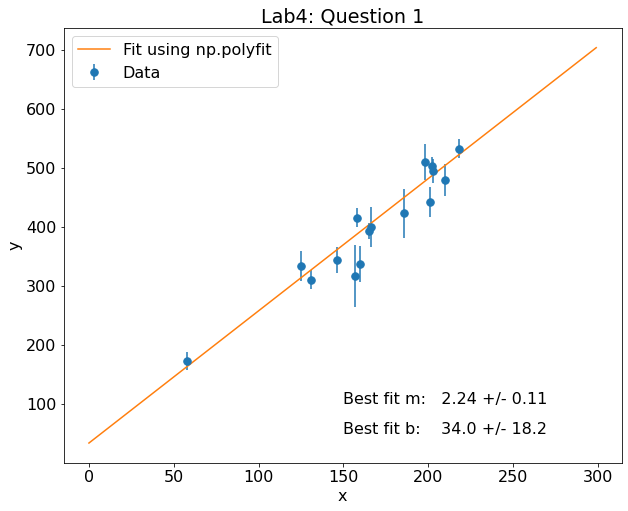

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plt.rcParams.update({'font.size': 16})


plt.errorbar(data['x'],data['y'],yerr = data['sigma_y'],fmt='.',label='Data',ms=15)

pfit = np.poly1d(p)
x=np.arange(0,300)
plt.plot(x,pfit(x),label='Fit using np.polyfit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Lab4: Question 1')
plt.text(150,100,'Best fit m:   {:0.2f} +/- {:0.2f} '.format(p[0],perr[0]))
plt.text(150,50,'Best fit b:    {:0.1f} +/- {:0.1f} '.format(p[1],perr[1]))

```{note}
Another way to turn `np.polyfit` fit (coefficient arrays) into actual curves is via `np.polyval`, which takes in the `p` above along with the array of values where you want to evaluate the polynomial.
```

### Question 2

Repeat the question above, however, this time write your own script to solve this problem by evaluating chi2 on a grid of m and b values. You should write a `chi2()` function that reads in 4 arguments `m,b,data_x,data_y,unc_y` (though you can call them what you want). You should then write a `fit_line()` or `minimize_chi2()` function that will, across your grid of $m$ and $b$ values, evaluate chi2 using your `chi2()` function. You may use the values above to guide your grid, making sure the grid spans at least 2-sigma in both directions.

Plot the chi2 values for all grid points. We suggest creating an array, `chi2_image`, which is a shape characterized by the lengthd of your `m_grid` and `b_grid`s. Then, as you double-for-loop over `m` and `b` values and calculate `chi2`, you can set `chi2_image[i,j]` to the output chi2 value. 

```{tip}
Remember, $m$ and $b$ values won't index your array directly. So you'll want to loop via something like `for i,m in enumerate(m_grid):` and `for j,b in enumerate(b_grid):` if you're going to do that.
```

While chi2 fitting is reliable for determining the best-fit values, it is not always easy to estimate errors on these parameters. For example, in the above example, we had to explicitly initialize a grid of parameters to fit on, and as soon as this grid has to get finely spaced, or moves into any number of dimensions > 2, everything gets much more computationally expensive to calculate, and understanding the chi-squared "surface" in multi-D becomes difficult. Additionally, we had to narrow in our range of $m$ and $b$ values to get it to work, but there may actually be a better solution elsewhere in parameter space that we're not accessing. 

In [12]:
def calc_chi2(m, b ,x ,y, yerr):
    '''
    Calculate chi2 value for a linear model.
    
    Parameters
    ----------
    m: float
        slope of the line
    b: float
        y-intercept of the line
    x, y: float
        data points to be fit
    yerr: float
        one sigma errors on the y-values
    Returns
    -------
    chi2 
        The value of chi2 
    '''
    
    f = m*x + b
    chi2 = np.sum((y - f)**2/yerr**2)
    
    return chi2

Next we need to set-up a grid of parameters to search through.   With two free parameters (m and b), this isn't too difficult, but quickly gets complicated with more parameters.

In [35]:
m_grid = np.arange(1.8,2.7,0.01)
b_grid = 1.*np.arange(-20,80,1)

m_arr,b_arr,chi2 = [],[],[]
chi2_min = 1e8 
m_min, b_min = 0,0

image = np.zeros(shape=(len(m_grid),len(b_grid)))
chi2 = []
for i,m in enumerate(m_grid):
    for j,b in enumerate(b_grid):
        
        c = calc_chi2(m,b,data['x'],data['y'],data['sigma_y'])
        
        chi2.append(c)
        m_arr.append(m)
        b_arr.append(b)
        image[i,j] = c
        if c < chi2_min:
            chi2_min = c
            m_min    = m
            b_min    = b
            
chi2 = np.array(chi2)
b_arr = np.array(b_arr)
m_arr = np.array(m_arr)

print('Best fit slope:     {:0.2f} '.format(m_min))
print('Best fit intercept: {:0.1f} '.format(b_min))
print('Minimum chi2:       {:0.1f} '.format(chi2_min))


Best fit slope:     2.24 
Best fit intercept: 34.0 
Minimum chi2:       18.7 


```{note}
In the above, we store the output $\chi^2$ values in two ways: in an array (`chi2`), and and in an "image" array in 2D at each m,b position. See how to plot the results from these two methods of storing the $\chi^2$ values below.
```

Text(0.5, 1.0, 'Lab 4: Question 2')

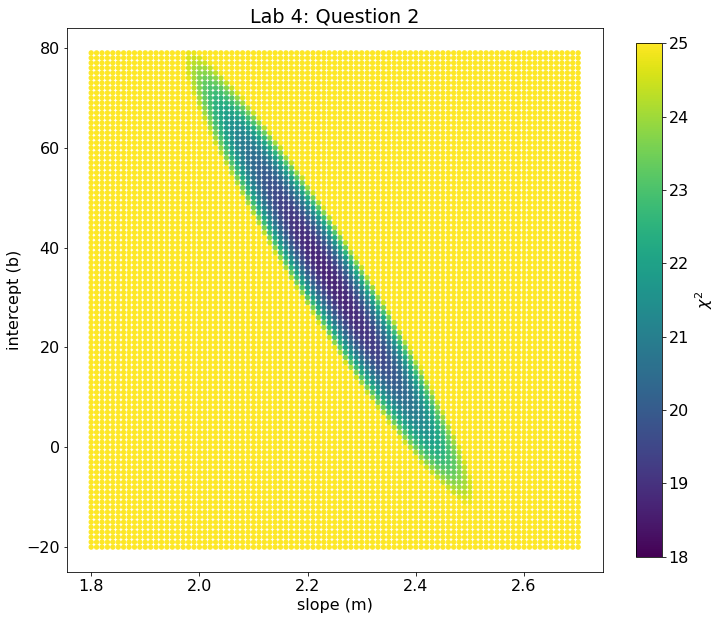

In [44]:

# Scatterplot using the chi2 array

fig, ax = plt.subplots(figsize=(12,10))
im = ax.scatter(m_arr,b_arr,c=chi2,marker='o',s=18,vmin=18,vmax = 25)

cb = plt.colorbar(im,ax=ax,shrink=0.945,label = '$\chi^2$')
ax.set_xlabel('slope (m)')
ax.set_ylabel('intercept (b)')
ax.set_title('Lab 4: Question 2')

Alternatively, we can plot the $\chi^2$ values a different way.

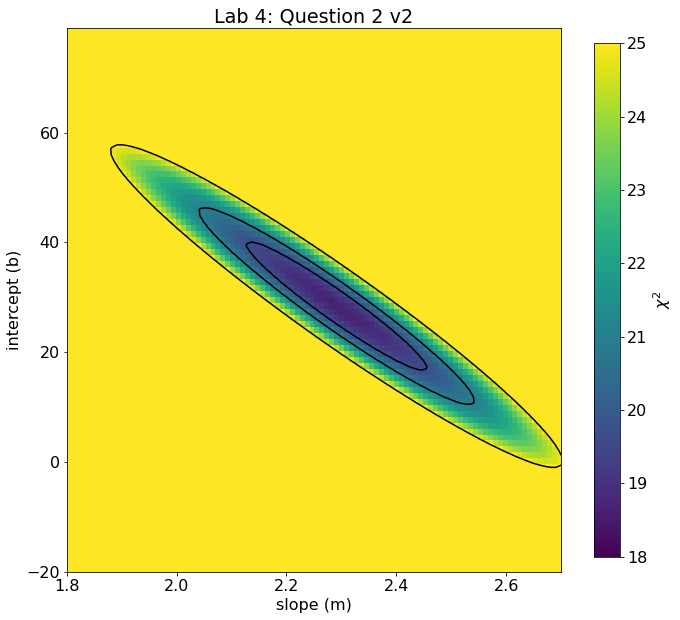

In [47]:
# using imshow on the 2D grid. This version makes contouring easier. 

extent = [np.min(m_grid),np.max(m_grid),np.min(b_grid),np.max(b_grid)]

fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(image,origin='lower',extent=extent,vmin=18,vmax=25,aspect=0.01)
cb = plt.colorbar(im,ax=ax,shrink=0.945,label = '$\chi^2$')
ax.set_xlabel('slope (m)')
ax.set_ylabel('intercept (b)')
ax.set_title('Lab 4: Question 2 v2')
ax.contour(image,levels=[chi2_min+1,chi2_min+2.3,chi2_min+6.17],colors='k',extent=extent)



```{note}
Note that the different "slopes" of the contours in the two versions is not because they are different, but because in the imaging sense, due to the differing ranges, the choice of pixel aspect ratio tends to flatten or steepen the apparent slope. The actual chi2 at any given m,b should match between the two.
```

### Question 3

Determine the best fit parameters and one-sigma errors from Question 2.  The best-fit value can either be the minimum chi2 value or (bonus) by fitting a function to your chi2 values and interpolating the best fit.

Determine the 1-sigma errors on your best-fit parameters. by noting where chi2 = chi2 + 1

In [48]:
msk = chi2 < (np.min(chi2) + 1.)

m_err = (np.max(m_arr[msk]) - np.min(m_arr[msk]))/2.
b_err = (np.max(b_arr[msk]) - np.min(b_arr[msk]))/2.

print('Best fit slope:     {:0.2f} +/- {:0.2f} '.format(m_min,m_err))
print('Best fit intercept: {:0.1f} +/- {:0.1f} '.format(b_min,b_err))

Best fit slope:     2.24 +/- 0.10 
Best fit intercept: 34.0 +/- 18.0 


Cool... our one sigma errors agree with Question 1 from above.

```{warning}
When looking at the $\chi^2$ distribution above, it is clear that there is covariance between $m$ and $b$ — to get a good fit, higher values of $b$ force shallower slopes and vice versa. When we are interested in the *two dimensional*, covariance-included uncertainty (that is, the joint uncertainty), we want the area of this chi2 grid that is parametrized by a $\Delta \chi^2 +2.3$ from the minimized $\chi^2$ value. On the other hand, if we care about the *individual* uncertainties in $m$ and $b$, we actually project out of this two dimensional space. In this case, the proper $\Delta \chi^2$ to use is $+1$. 
```

## Part 2:   MCMC Fitting

While chi2 is a good method for determining best-fitting values, it less reliable in determining errors on those parameters.   If your science question requires good error estimates and/or if your model contains more than a few parameters, Monte Carlo (MCMC) is a popular tool.


https://ui.adsabs.harvard.edu/abs/2018ApJS..236...11H/abstract


You will need to install two packages for this work inside of your A330 environment:

```
conda install emcee
conda install corner
```

### Question 4

Read Hogg et al. 2018 and do Problems 1-4.   

For Problem 1, you are welcome to explore just the mean and varience.

For Problem 2, you have no choice.  Use python :)

For Problem 4, I found it easier to do 4b first, then 4a.

### Answer for Problem 1 from Hogg et al

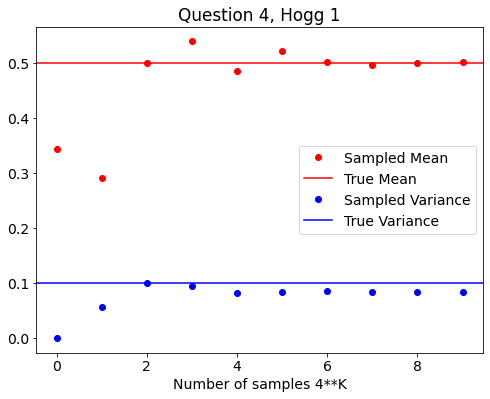

In [55]:
sample_mean = []
sample_var = []

# INCREASE NUMBER OF SAMPLES IN EACH LOOP
for i in range(10):
    K=4**i
    
    # random samples from a uniform distribution between 0-1
    x = np.random.rand(K)              
    
    mean = (1./K) * np.sum(x)           # DEF OF SAMPLE MEAN
    var  = (1./K) * np.sum((x-mean)**2) # DEF OF SAMPLE VARIANCE

    sample_mean.append(mean)
    sample_var.append(var)

    
# PLOT RESULTS ON SAME PLOT
fig,ax = plt.subplots(figsize=(8,6))
plt.rcParams.update({'font.size': 14})

ax.plot(np.arange(10),sample_mean,'ro',label='Sampled Mean')
ax.set_title('Question 4, Hogg 1')
plt.axhline(y=0.5,color='r',label='True Mean')

ax.plot(np.arange(10),sample_var,'bo',label='Sampled Variance')
ax.set_xlabel('Number of samples 4**K')
ax.axhline(y=0.1,color='b',label='True Variance')

#ax.set_scale('log')
ax.legend()

### Answer for Problem 2 from Hogg et al 2018

In [57]:
def gaussian(x,mu,sig) :
    '''
    Gaussian distribution
    
    Parameters
    ----------
    x: float array
        Values where Gaussian will be evaluated
    mu, sig: float
        Mean and sigma of the Gaussian
    Returns
    -------
    gaussian 
        The value of the Gaussian evaluated at x 
    '''
    return np.exp(-0.5*((x-mu)/sig)**2)


Text(0.5, 1.0, 'Question 4: Hogg Problem 2')

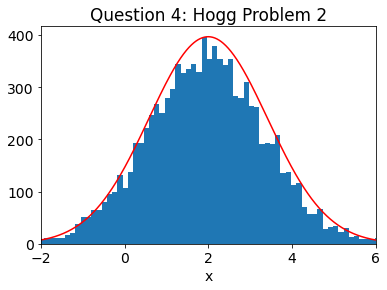

In [62]:
mn = 2
sg = np.sqrt(2.)       
xk = 0                 # INITIALIZE SAMPLER

samples = []
for i in range(10**4):
    xp = np.random.normal(xk,1)        # PROPOSAL DISTRIBUTION
                                       # GAUSSAIAN SIGMA = 1
    r = np.random.rand()
    
    f1 = gaussian(xp, mn, sg)          # NEW SAMPLE
    f2 = gaussian(xk, mn, sg)          # OLD SAMPLE
    ratio = f1/f2

    if (ratio > r):                    # ACCEPT OR REJECT?
        samples.append(xp)
        xk=xp
    else:
        samples.append(xk)
        
        
# PLOT SAMPLES
samples_prob2 = samples   # SAVE FOR LATER
n, bins, patches = plt.hist(samples,bins=75)
mx = np.max(n)

# PLOT TRUTH
a=np.arange(1000)/100. - 3.
true_dist = gaussian(a, mn, sg)
plt.plot(a,mx*true_dist,'r')
plt.xlim(-2,6)
plt.xlabel('x')
plt.title('Question 4: Hogg Problem 2')

### Answer for Problem 3 from Hogg et al 2018

In [70]:
def pdf3(x):
    '''
    Top Hat between 3 to 7 distribution for Problem 3
    
    Parameters
    ----------
    x: float array
        Values where Top Hat will be evaluated
    Returns
    -------
    p 
        returns 1 if inside tophat, 0 if outside 
    '''  
    if (x >= 3) & (x<=7):
        p = 1.
    else:
        p=0.
    return p

Text(0.5, 1.0, 'Hogg Problem 3')

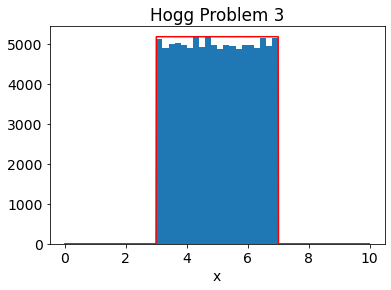

In [71]:
xk = 6.                # NEED TO START INSIDE DISTRIBUTION\

samples = []
for i in range(10**5):
    xp = np.random.normal(xk,1)   # PROPOSAL DISTRIBUTION
    r = np.random.rand()
    
    f1 = pdf3(xp)                 # SAMPLE NEW
    f2 = pdf3(xk)                 # SAMPLE NEW
    ratio = f1/f2
     
    if (ratio > r):               # COMPARE
        samples.append(xp)
        xk=xp
    else:
        samples.append(xk)


# PLOT SAMPLES
n, bins, patches = plt.hist(samples,bins=20)
mx = np.max(n)

# PLOT TRUTH
a=np.arange(1000)/100.
true_dist= (a >=3) & (a<=7)
plt.plot(a,mx*true_dist,'r')
plt.xlabel('x')
plt.title('Hogg Problem 3')

### Answer for Problem 4a from Hogg et al 2018

In [119]:
from scipy import stats

def pdf4a(x,y) :
    '''
    Two dimensional Gaussian distribution, 
    
    Parameters
    ----------
    x,y: float array
        Values where 2D Gaussian will be evaluated
        
    mu, sig: float
        Mean and sigma of the Gaussian
    Returns
    -------
    gaussian 
        The value of the Gaussian evaluated at x, y 
    '''
    
    mean =  [0,0]
    cov  =  [[2.0,1.2],[1.2,2.0]]
    gauss = stats.multivariate_normal(mean, cov)
    
    return gauss.pdf([x,y]) 



In [120]:
xk = 6.                # NEED TO START INSIDE DISTRIBUTION
yk = 5.

xsamples, ysamples = [], []

for i in range(10**4):

    ind = [[1.0,0],[0,1]]
    xp,yp = np.random.multivariate_normal([xk,yk],ind)  

    r = np.random.rand()
    
    f1 = pdf4a(xp,yp)
    f2 = pdf4a(xk,yk)
    ratio = f1/f2

    if (ratio > r):
        xsamples.append(xp)
        xk=xp
        ysamples.append(yp)
        yk=yp
    else:
        xsamples.append(xk)
        ysamples.append(yk)
        
data = np.column_stack((ysamples,xsamples))

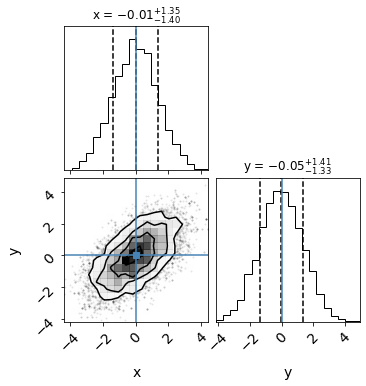

In [122]:
import corner
figure = corner.corner(data, truths=[0,0],labels=["x", "y"],
                       quantiles=[0.16, 0.5, 0.84],show_titles=True, 
                       title_kwargs={"fontsize": 12})



### Answer for Problem 4b from Hogg et al 2018

In [74]:
def pdf4b(x,y):
    '''
    2D Top Hat distribution for Problem 4
    Hard-wired between 3-7
    
    Parameters
    ----------
    x,y: float array
        Values where Top Hat will be evaluated
    Returns
    -------
    p 
        returns 1 if inside tophat, 0 if outside 
    ''' 
    if (x >= 3) & (x<=7) & (y >= 1) & (y <=9):
        p = 1.
    else:
        p=0.
    return p

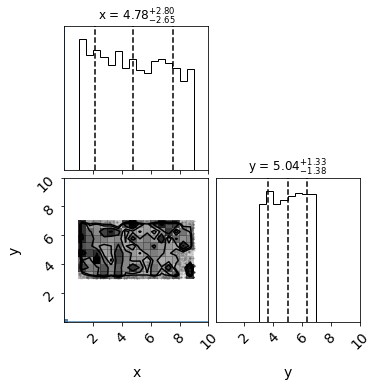

In [76]:
xk = 6.                # NEED TO START INSIDE DISTRIBUTION
yk = 5.

xsamples, ysamples = [], []
ind = [[2.0,1.2],[1.2,2.0]]

for i in range(10**4):
    xp,yp = np.random.multivariate_normal([xk,yk],ind)  

    r = np.random.rand()
    
    f1 = pdf4b(xp,yp)
    f2 = pdf4b(xk,yk)
    ratio = f1/f2

    if (ratio > r):
        xsamples.append(xp)
        xk=xp
        ysamples.append(yp)
        yk=yp
    else:
        xsamples.append(xk)
        ysamples.append(yk)
        
data = np.column_stack((ysamples,xsamples))

figure = corner.corner(data, truths=[0,0],labels=["x", "y"],
                       quantiles=[0.16, 0.5, 0.84],show_titles=True, 
                       title_kwargs={"fontsize": 12},range=([0,10],[0,10]))



### Question 5

While the above problems should give you a sense for how MCMC works, most reseach problems use standard packages to run MCMC.  MCMC packages in astronomy include emcee, MultiNest,  Dynasty.   


Write an MCMC to evaluate the data in Question 1+2 above using emcee.   We suggest checking out the guide to MCMC here:

https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html


We suggest 20 walkers and 2000 steps for your sampler.    Plot both the sampler chains and a corner plot of the results.   

Compare the best fit values for m and b from the chi2 and MCMC, as well as their errors.   

In [91]:
import emcee
import corner

In [125]:
# LOAD DATA FROM HOGG et al 2010, Table 1
data = ascii.read('hogg_2010_data.txt')

# SKIP THE FIRST FEW DATA POINTS
m=data['ID'] > 4
data=data[m]

In [126]:
def lnprob(theta,x,y,sigma):
    '''
    Evaluate whether to accept or 
    
    Parameters
    ----------
    x,y: float array
        Values where Top Hat will be evaluated
    Returns
    -------
    p 
        returns 1 if inside tophat, 0 if outside 
    ''' 
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta, x, y, sigma)



def lnprior(theta):
    '''
    Evaluate whether sample falls inside of priors
    
    Parameters
    ----------
    theta: float array
        Current values of fitted parameters
        
    Returns
    -------
        returns 0 if inside prior, -inf if outside 
    ''' 
    if (0 < theta[0] < 5) & (-30 < theta[1] < 200):
        return 0.0
    
    return -np.inf


def lnlike(theta,x,y,sigma):
    '''
    Evaluate the log-likelihood
    
    Parameters
    ----------
    theta: float array
        Current values of fitted parameters
        
    x,y, sigma: float arrays
        Data points and one sigma errors

    Returns
    -------
    lnl
        log-likelihood value  
    ''' 
    # MAKE MODEL
    model = theta[0]*x + theta[1]

    # EVALUATE LIKELIHOOD
    chi2 = ((y - model)**2)/(sigma**2)
    lnl  = -0.5 * np.sum(chi2)
    
    return lnl


def initialize_walkers(mguess,bguess):
    '''
    Initialize the walkers using an initial guess
    
    Parameters
    ----------
    mguess, bguess: float value
        Rough initial guess of parameters
    Returns
    -------
    ndim, nwalkers, p0

    ''' 
        
    # Two free parameters (m,b) and 20 walkers
    ndim, nwalkers = 2, 20
    p0 =  np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

    # initialize slope 
    p0[:,0] = (p0[:,0]*4. - 2) + mguess
    
    # initialize intercept
    p0[:,1] = (p0[:,1] * 60 - 30) + bguess
    
    return ndim,nwalkers,p0


In [127]:
mguess = 2
bguess = 30

max_n=3000
ndim, nwalkers, p0 = initialize_walkers(mguess,bguess)

# INITIALIZE SAMPLER
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data['x'],data['y'],data['sigma_y']))

# RUN MCMC
pos, prob, state = sampler.run_mcmc(p0, max_n)

In [128]:
# As a bonus, we can determine the number of burnin samples and whether the chains converged.

tau    = sampler.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
converged = np.all(tau * 100 < sampler.iteration)
print('Number of initial burnin samples:',burnin)
print('Did the chains converge?',converged)

Number of initial burnin samples: 54
Did the chains converge? True


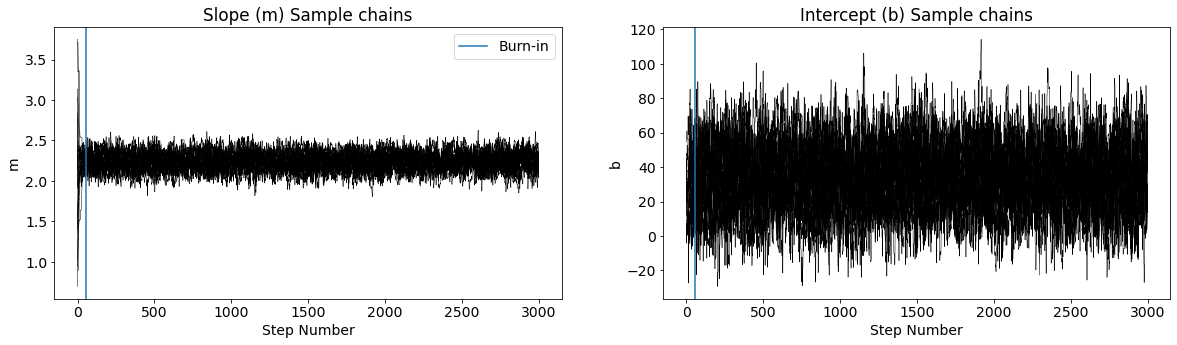

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))

for ii in range(20):
    ax1.plot(sampler.chain[ii,:,0], color="k",linewidth=0.5)

for ii in range(20):
    ax2.plot(sampler.chain[ii,:,1], color="k",linewidth=0.5)


ax1.set_ylabel('m')
ax2.set_ylabel('b')
ax1.set_xlabel('Step Number')
ax2.set_xlabel('Step Number')

ax1.set_title('Slope (m) Sample chains')
ax2.set_title('Intercept (b) Sample chains')

ax1.axvline(burnin,label='Burn-in')
ax2.axvline(burnin)
ax1.legend()

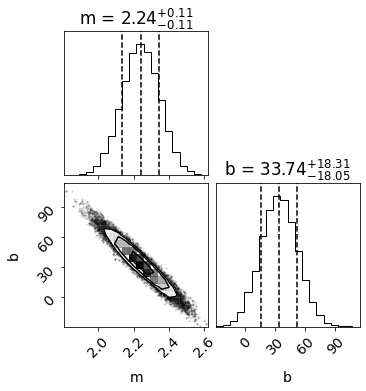

In [130]:
# PLOT CORNER
labels=['m','b']
burnin = 100
samples   = sampler.chain[:, burnin:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=labels,show_titles=True,quantiles=[0.16, 0.5, 0.84])


The MCMC returns similar best fit values and one-sigma errors as our chi2 method above!